In [1]:
import wandb
wandb.login()
import os
os.environ['WANDB_PROJECT'] = 'shortest_v3_model'
import pandas as pd
import networkx as nx
import logging
from random import shuffle
import pandas as pd
from matplotlib import pyplot as plt
import csrgraph as cg
import numpy as np
import random
import string
from itertools import combinations
import pickle
import gc
import os
import json
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from tqdm import tqdm


#os.environ['WANDB_MODE'] = 'disabled'

# set current directory
os.chdir("/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS")

wandb: Currently logged in as: carobgt (carobgt-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import os
import shutil
import random
import networkx as nx
import numpy as np
import string
from tqdm import tqdm


def get_canonical_graph(size):
    """Creates a grid graph with stable integer nodes (0, 1, 2...) for enumeration."""
    G = nx.DiGraph()
    nodes = list(range(size*size))
    for r in range(size):
        for c in range(size):
            idx = r * size + c
            if c < size - 1: G.add_edge(nodes[idx], nodes[idx + 1], direction='EAST')
            if c > 0: G.add_edge(nodes[idx], nodes[idx - 1], direction='WEST')
            if r < size - 1: G.add_edge(nodes[idx], nodes[idx + size], direction='SOUTH')
            if r > 0: G.add_edge(nodes[idx], nodes[idx - size], direction='NORTH')
    return G

def get_graph_with_random_names(size):
    """Creates a grid graph with unique random names, used for generating examples."""
    num_nodes = size * size
    names = set()
    while len(names) < num_nodes:
        names.add(''.join(random.choices(string.ascii_lowercase, k=2)))
    nodes = list(names)
    # IMPORTANT!!! shuffle nodes to break hash map order
    random.shuffle(nodes)
    G = nx.DiGraph()
    node_map = {i: nodes[i] for i in range(num_nodes)}
    for r in range(size):
        for c in range(size):
            idx = r * size + c
            u = node_map[idx]
            if c < size - 1: G.add_edge(u, node_map[idx + 1], direction='EAST')
            if c > 0: G.add_edge(u, node_map[idx - 1], direction='WEST')
            if r < size - 1: G.add_edge(u, node_map[idx + size], direction='SOUTH')
            if r > 0: G.add_edge(u, node_map[idx - size], direction='NORTH')
    return G

def find_all_hamiltonian_path_shapes(G):
    """Exhaustively finds all unique Hamiltonian path shapes (sequences of directions)."""
    all_shapes = set()
    num_nodes = len(G.nodes())
    def _search(current_node, path_nodes, path_directions):
        if len(path_nodes) == num_nodes:
            all_shapes.add(tuple(path_directions))
            return
        for neighbor in G.successors(current_node):
            if neighbor not in path_nodes:
                direction = G.edges[current_node, neighbor]['direction']
                path_nodes.add(neighbor)
                path_directions.append(direction)
                _search(neighbor, path_nodes, path_directions)
                path_directions.pop()
                path_nodes.remove(neighbor)
    print("Enumerating all unique Hamiltonian path shapes... (this may take a moment)")
    for start_node in tqdm(list(G.nodes()), desc="Enumerating Shapes"):
        _search(start_node, {start_node}, [])
    return list(all_shapes)

def save_shapes_to_file(shapes, filename):
    """Saves a list of shape tuples to a file, one per line."""
    print(f"Saving {len(shapes)} shapes to {filename}...")
    with open(filename, "w") as f:
        for shape in shapes:
            # Join the directions with a comma for easy parsing later
            f.write(",".join(shape) + "\n")

def load_shapes_from_file(filename):
    """Loads a list of shapes from a file."""
    print(f"Loading shapes from {filename}...")
    shapes = []
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                # Split by comma and create a tuple
                shapes.append(tuple(line.split(",")))
    return shapes

def build_path_from_shape(G, shape):
    """Constructs a node path in graph G that follows a given shape."""
    node_moves = {u: {data['direction']: v for _, v, data in G.out_edges(u, data=True)} for u in G.nodes()}
    possible_starts = list(G.nodes())
    random.shuffle(possible_starts)
    for start_node in possible_starts:
        path = [start_node]
        current_node = start_node
        valid_path = True
        for direction in shape:
            if direction in node_moves[current_node]:
                next_node = node_moves[current_node][direction]
                path.append(next_node)
                current_node = next_node
            else:
                valid_path = False
                break
        if valid_path:
            return path
    raise ValueError("Could not construct a path for the given shape in the graph.")

def format_path_to_string(path, G):
    """Converts a list of nodes into a 'NODE DIR NODE...' string."""
    if not path or len(path) < 2: return path[0] if path else ""
    path_str = ""
    for i in range(len(path) - 1):
        u, v = path[i], path[i+1]
        direction = G.edges[u, v]['direction']
        path_str += f"{u} {direction} "
    path_str += path[-1]
    return path_str


def generate_hamiltonian_test_example(G, shape):
    path_nodes = build_path_from_shape(G, shape)
    context_str = format_path_to_string(path_nodes, G)
    start_node, goal_node = random.sample(path_nodes, 2)
    shortest_path_nodes = next(nx.all_shortest_paths(G, source=start_node, target=goal_node))
    task_instruction = f"[SHORTEST] [START_NODE] {start_node} [GOAL] {goal_node}"
    target_str = format_path_to_string(shortest_path_nodes, G)
    prompt = f"[SOS] {context_str} [SEP] {task_instruction} [PLAN]"
    target = f"{target_str} [EOS]"
    return prompt, target

def generate_and_save_split_dataset(n_examples, grid_size, allowed_shapes, output_file_path, description=""):
    print(f"--- Generating {n_examples} examples for {description} ---")
    with open(output_file_path, "w", encoding="utf-8") as f:
        pbar = tqdm(range(n_examples), desc=f"Generating {description}")
        for _ in pbar:
            shape_to_build = random.choice(allowed_shapes)
            G = get_graph_with_random_names(grid_size)
            example = generate_hamiltonian_test_example(G, shape_to_build)
            if example:
                prompt, target = example
                f.write(f"{prompt} {target}\n")


In [ ]:


if __name__ == "__main__":
    NUM_TRAIN_EXAMPLES = 1000000
    NUM_TEST_EXAMPLES = 10000
    GRID_SIZE = 4
    SHAPES_FILENAME = "hamiltonian_shapes_4x4.txt"

    random.seed(42)
    np.random.seed(42)

    output_dir = "shortest_v2_data"
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    if os.path.exists(SHAPES_FILENAME):
        all_shapes = load_shapes_from_file(SHAPES_FILENAME)
    # else:
    #     canonical_graph = get_canonical_graph(GRID_SIZE)
    #     all_shapes = find_all_hamiltonian_path_shapes(canonical_graph)
    #     save_shapes_to_file(all_shapes, SHAPES_FILENAME)
    
    print(f"\nSuccessfully loaded/found {len(all_shapes)} unique Hamiltonian path shapes.")


    random.shuffle(all_shapes)
    split_idx = int(0.9 * len(all_shapes))
    train_shapes = all_shapes[:split_idx]
    eval_shapes = all_shapes[split_idx:]

    print(f"Splitting into {len(train_shapes)} shapes for training and {len(eval_shapes)} for evaluation.")

    train_file_path = os.path.join(output_dir, "train.txt")
    generate_and_save_split_dataset(
        n_examples=NUM_TRAIN_EXAMPLES,
        grid_size=GRID_SIZE,
        allowed_shapes=train_shapes,
        output_file_path=train_file_path,
        description="Train Set (Seen Shapes)"
    )

    test_file_path = os.path.join(output_dir, "test.txt")
    generate_and_save_split_dataset(
        n_examples=NUM_TEST_EXAMPLES,
        grid_size=GRID_SIZE,
        allowed_shapes=eval_shapes,
        output_file_path=test_file_path,
        description="Test Set (Unseen Shapes)"
    )

    print("\n--- Shape-split data generation process finished successfully! ---")

Loading shapes from hamiltonian_shapes_4x4.txt...

Successfully loaded/found 552 unique Hamiltonian path shapes.
Splitting into 496 shapes for training and 56 for evaluation.
--- Generating 1000000 examples for Train Set (Seen Shapes) ---


Generating Train Set (Seen Shapes): 100%|██████████| 1000000/1000000 [01:45<00:00, 9462.52it/s]


--- Generating 10000 examples for Test Set (Unseen Shapes) ---


Generating Test Set (Unseen Shapes): 100%|██████████| 10000/10000 [00:01<00:00, 9569.06it/s]


--- Shape-split data generation process finished successfully! ---


In [36]:
# Analysis tools
from transformers import GPT2Tokenizer
import numpy as np
def analyse_dataset(file_path, tokenizer_path):
    """
    Analyze context/target ratio in existing dataset.
    """
    tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path)
    
    total_context_tokens = 0
    total_target_tokens = 0
    ratios = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= 1000:  # Analyze first 1000 examples
                break
                
            parts = line.strip().split()
            sep_index = parts.index('[PLAN]')
            prompt = ' '.join(parts[:sep_index])
            target = ' '.join(parts[sep_index + 1:])

            
            # Extract context (before [SEP])
            if '[SEP]' in prompt:
                context_part = prompt.split('[SEP]')[0]
            else:
                context_part = prompt
            
            context_tokens = len(tokenizer.encode(context_part))
            target_tokens = len(tokenizer.encode(target))
            
            if target_tokens > 0:
                ratio = context_tokens / target_tokens
                ratios.append(ratio)
                total_context_tokens += context_tokens
                total_target_tokens += target_tokens
    
    if ratios:
        avg_ratio = total_context_tokens / total_target_tokens
        median_ratio = np.median(ratios)
        
        print(f"Dataset Analysis ({len(ratios)} examples):")
        print(f"Average context/target ratio: {avg_ratio:.2f}")
        print(f"Median ratio: {median_ratio:.2f}")
        print(f"Ratio range: {min(ratios):.2f} - {max(ratios):.2f}")
        
        if avg_ratio > 3.0:
            print("Context heavily dominates - consider shorter contexts")
        elif avg_ratio < 0.5:
            print("Target dominates - consider longer contexts") 
        else:
            print("Reasonable balance")

analyse_dataset("shortest_v2_data/train.txt", "gv6_tokenizer")

Dataset Analysis (1000 examples):
Average context/target ratio: 4.00
Median ratio: 3.69
Ratio range: 2.18 - 6.86
Context heavily dominates - consider shorter contexts


**CUSTOM TOKENIZER**

trained in tokenizer_training.ipynb


In [37]:
class GPT:

    def __init__(self, base_model=None, base_model_name='gpt2', vocab_size=100):
        self.base_model = base_model
        self.base_model_name = base_model_name
        self.vocab_size = vocab_size

        if self.base_model is not None:
            self.tokenizer = GPT2Tokenizer.from_pretrained(base_model)
            self.model = GPT2LMHeadModel.from_pretrained(base_model)
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def continue_input(self, input_sequence, max_new_tokens=5, num_return_sequences=1, no_repeat_ngram_size=0,
                       do_sample=False, temperature=0.7, num_beams=1):
        input_ids = self.tokenizer.encode(input_sequence, return_tensors='pt')

        # Generate text
        output = self.model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            num_return_sequences=num_return_sequences,
            num_beams=num_beams,
            no_repeat_ngram_size=no_repeat_ngram_size,
            do_sample=do_sample,
            temperature=temperature,
        )

        # Decode the output
        sequence = output[0].tolist()
        text = self.tokenizer.decode(sequence)
        return text
    
    

In [38]:
def load_pkl(pth):
    with open(pth, 'rb') as f:
        d = pickle.load(f)
    return d

def is_valid_path(sequence, graphs):
    # Split the sequence into parts
    parts = sequence.split()

    # Extract nodes and edges; nodes are at even indices, edges at odd indices
    nodes = parts[::2]
    edges = parts[1::2]

    # Convert edges to a lowercase version for comparison (assuming all edges in graphs are lowercase)
    edges = [edge.lower() for edge in edges]

    # Iterate over each graph to check if the path exists
    for graph in graphs:
        path_exists = True
        for i in range(len(nodes) - 1):
            # Check if the current graph has the edge between the current node and the next node
            if not graph.has_edge(nodes[i], nodes[i+1]):
                path_exists = False
                break

        # If path exists in the current graph, return True
        if path_exists:
            return True

    # If none of the graphs contain the path, return False
    return False

In [ ]:
from transformers import AutoConfig, GPT2Tokenizer
import os

TOKENIZER_PATH = "gv6_tokenizer"
CONFIG_SAVE_PATH = "shortest_v2_config"


print(f"Loading custom tokenizer from: {TOKENIZER_PATH}")
my_custom_tokenizer = GPT2Tokenizer.from_pretrained(TOKENIZER_PATH)

print("Loading base gpt2 config...")
config = AutoConfig.from_pretrained('gpt2')

print(f"Overriding config vocab_size. Old: {config.vocab_size}, New: {len(my_custom_tokenizer)}")
config.vocab_size = len(my_custom_tokenizer)

print("Updating special token IDs in the config...")
config.bos_token_id = my_custom_tokenizer.bos_token_id
config.eos_token_id = my_custom_tokenizer.eos_token_id

config.pad_token_id = my_custom_tokenizer.pad_token_id
print(f"Set pad_token_id to: {config.pad_token_id}")

os.makedirs(CONFIG_SAVE_PATH, exist_ok=True)
config.save_pretrained(CONFIG_SAVE_PATH)

print(f"\nCustom model config saved successfully to: {CONFIG_SAVE_PATH}")

Loading custom tokenizer from: gv6_tokenizer
Loading base gpt2 config...
Overriding config vocab_size. Old: 50257, New: 1031
Updating special token IDs in the config...
Set pad_token_id to: 0

Custom model config saved successfully to: shortest_v2_config


In [ ]:
import os

project_cache_path = os.path.join(os.getcwd(), '.cache', 'huggingface_datasets')
os.makedirs(project_cache_path, exist_ok=True)

os.environ['HF_DATASETS_CACHE'] = project_cache_path

print(f"Hugging Face datasets cache is now set to: {os.environ['HF_DATASETS_CACHE']}")

wandb_path = os.path.join(os.getcwd(), 'wandb_local_runs')
os.makedirs(wandb_path, exist_ok=True)

os.environ['WANDB_DIR'] = wandb_path
print(f"Wandb local run directory set to: {os.environ['WANDB_DIR']}")

import os
os.environ["WANDB__SERVICE_WAIT"] = "120"

Hugging Face datasets cache is now set to: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/.cache/huggingface_datasets
Wandb local run directory set to: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/wandb_local_runs


In [ ]:
import os
import gc
import wandb

def train_model_script(num_epochs=1,
                       output_dir='sv2_model_fixed', 
                       lr=5e-05):
    gc.collect()
    wandb.login()
    os.environ['WANDB_PROJECT'] = 'shortest_path_models'

    save_steps = 500
    save_total_limit = 10
    weight_decay = 0.1
    beta2 = 0.98
    
    data_dir = 'shortest_v2_data' 
    tokenizer_dir = 'gv6_tokenizer'
    config_dir = 'shortest_v2_config'
    
    train_path = f'./{data_dir}/train.txt'
    test_path = f'./{data_dir}/test.txt'

    command = f"""
    python3 ./train_shortest.py \\
        --config_name {config_dir} \\
        --tokenizer_name {tokenizer_dir} \\
        --train_file {train_path} \\
        --validation_file {test_path} \\
        --per_device_train_batch_size 256 \\
        --per_device_eval_batch_size 256 \\
        --do_train \\
        --do_eval \\
        --output_dir {output_dir} \\
        --num_train_epochs {num_epochs} \\
        --save_strategy 'steps' \\
        --save_steps {save_steps} \\
        --save_total_limit {save_total_limit} \\
        --eval_strategy 'steps' \\
        --eval_steps 500 \\
        --warmup_steps 0 \\
        --learning_rate {lr} \\
        --report_to 'wandb' \\
        --lr_scheduler_type cosine \\
        --weight_decay {weight_decay} \\
        --adam_beta2 {beta2} \\
        --fp16 True
    """
    
    print("--- Running Command ---")
    print(command)
    print("-----------------------")
    
    os.system(command)

In [42]:
#!rm -rf sv2_model_fixed/
!mkdir sv2_model_fixed/

In [43]:
train_model_script(num_epochs=20,
                   output_dir='sv2_model_fixed',
                   lr=1e-04)


--- Running Command ---

    python3 ./train_shortest.py \
        --config_name shortest_v2_config \
        --tokenizer_name gv6_tokenizer \
        --train_file ./shortest_v2_data/train.txt \
        --validation_file ./shortest_v2_data/test.txt \
        --per_device_train_batch_size 256 \
        --per_device_eval_batch_size 256 \
        --do_train \
        --do_eval \
        --output_dir sv2_model_fixed \
        --num_train_epochs 20 \
        --save_strategy 'steps' \
        --save_steps 500 \
        --save_total_limit 10 \
        --eval_strategy 'steps' \
        --eval_steps 500 \
        --warmup_steps 0 \
        --learning_rate 0.0001 \
        --report_to 'wandb' \
        --lr_scheduler_type cosine \
        --weight_decay 0.1 \
        --adam_beta2 0.98 \
        --fp16 True
    
-----------------------


/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


INFO:__main__:Loading tokenizer, config, and model...
INFO:__main__:--- Initializing a new model from scratch ---
INFO:__main__:Synchronized model embedding size with tokenizer. New size: 1031


Generating train split: 1000000 examples [00:02, 480600.46 examples/s]
Generating validation split: 10000 examples [00:00, 374474.71 examples/s]
Map (num_proc=24): 100%|██████████| 10000/10000 [00:00<00:00, 18470.36 examples/s]
/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/./train_shortest.py:227: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


INFO:__main__:*** Starting Training ***


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: carobgt (carobgt-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.20.1
wandb: Run data is saved locally in /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/wandb_local_runs/wandb/run-20250809_195724-yf1zeewk
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run sv2_model_fixed
wandb: ⭐️ View project at https://wandb.ai/carobgt-ucl/shortest_path_models
wandb: 🚀 View run at https://wandb.ai/carobgt-ucl/shortest_path_models/runs/yf1zeewk
  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 2.0282, 'grad_norm': 1.1174640655517578, 'learning_rate': 9.998997839877468e-05, 'epoch': 0.13}



 98%|█████████▊| 39/40 [00:05<00:00,  7.05it/s]
                                                     
100%|██████████| 40/40 [00:06<00:00,  5.56it/s]
                                               

{'eval_loss': 1.2690157890319824, 'eval_token_accuracy': 0.6745680370319447, 'eval_exact_match_accuracy': 0.0, 'eval_runtime': 6.274, 'eval_samples_per_second': 1593.892, 'eval_steps_per_second': 6.376, 'epoch': 0.13}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 1.2409, 'grad_norm': 1.0583919286727905, 'learning_rate': 9.995975649895321e-05, 'epoch': 0.26}



 95%|█████████▌| 38/40 [00:05<00:00,  6.89it/s]
                                                      
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]
                                               

{'eval_loss': 1.1782017946243286, 'eval_token_accuracy': 0.6728722672899766, 'eval_exact_match_accuracy': 0.0, 'eval_runtime': 5.9795, 'eval_samples_per_second': 1672.392, 'eval_steps_per_second': 6.69, 'epoch': 0.26}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 1.1771, 'grad_norm': 0.9776811003684998, 'learning_rate': 9.990934635126753e-05, 'epoch': 0.38}



 95%|█████████▌| 38/40 [00:05<00:00,  6.89it/s]
                                                      
100%|██████████| 40/40 [00:05<00:00,  7.05it/s]
                                               

{'eval_loss': 1.133472204208374, 'eval_token_accuracy': 0.6711031669645722, 'eval_exact_match_accuracy': 0.0, 'eval_runtime': 5.95, 'eval_samples_per_second': 1680.672, 'eval_steps_per_second': 6.723, 'epoch': 0.38}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 1.1444, 'grad_norm': 0.989952802658081, 'learning_rate': 9.983876832596415e-05, 'epoch': 0.51}



 95%|█████████▌| 38/40 [00:05<00:00,  6.90it/s]
                                                      
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 1.1064256429672241, 'eval_token_accuracy': 0.6708831752142628, 'eval_exact_match_accuracy': 0.0, 'eval_runtime': 5.9329, 'eval_samples_per_second': 1685.516, 'eval_steps_per_second': 6.742, 'epoch': 0.51}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 1.1217, 'grad_norm': 0.9728642702102661, 'learning_rate': 9.974805094293126e-05, 'epoch': 0.64}



 95%|█████████▌| 38/40 [00:05<00:00,  6.90it/s]
                                                      
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 1.090122103691101, 'eval_token_accuracy': 0.6709198405059811, 'eval_exact_match_accuracy': 0.0, 'eval_runtime': 5.9462, 'eval_samples_per_second': 1681.75, 'eval_steps_per_second': 6.727, 'epoch': 0.64}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 1.1031, 'grad_norm': 0.9789372086524963, 'learning_rate': 9.963723086017407e-05, 'epoch': 0.77}



 95%|█████████▌| 38/40 [00:05<00:00,  6.90it/s]
                                                      
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]
                                               

{'eval_loss': 1.075084924697876, 'eval_token_accuracy': 0.6702506989321234, 'eval_exact_match_accuracy': 0.0, 'eval_runtime': 5.9601, 'eval_samples_per_second': 1677.833, 'eval_steps_per_second': 6.711, 'epoch': 0.77}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 1.0903, 'grad_norm': 1.086523175239563, 'learning_rate': 9.950635285900171e-05, 'epoch': 0.9}



 95%|█████████▌| 38/40 [00:05<00:00,  6.89it/s]
                                                      
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]
                                               

{'eval_loss': 1.0618865489959717, 'eval_token_accuracy': 0.6689857463678446, 'eval_exact_match_accuracy': 0.0, 'eval_runtime': 5.9475, 'eval_samples_per_second': 1681.368, 'eval_steps_per_second': 6.725, 'epoch': 0.9}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 1.0674, 'grad_norm': 1.1490004062652588, 'learning_rate': 9.935546982593147e-05, 'epoch': 1.02}



 95%|█████████▌| 38/40 [00:05<00:00,  6.90it/s]
                                                      
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]
                                               

{'eval_loss': 0.9945839047431946, 'eval_token_accuracy': 0.7038177735001604, 'eval_exact_match_accuracy': 0.0133, 'eval_runtime': 5.9369, 'eval_samples_per_second': 1684.382, 'eval_steps_per_second': 6.738, 'epoch': 1.02}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.9442, 'grad_norm': 1.5353647470474243, 'learning_rate': 9.9184642731318e-05, 'epoch': 1.15}



 95%|█████████▌| 38/40 [00:05<00:00,  6.89it/s]
                                                      
100%|██████████| 40/40 [00:05<00:00,  7.05it/s]
                                               

{'eval_loss': 0.9152400493621826, 'eval_token_accuracy': 0.7339383106466841, 'eval_exact_match_accuracy': 0.0145, 'eval_runtime': 5.9787, 'eval_samples_per_second': 1672.593, 'eval_steps_per_second': 6.69, 'epoch': 1.15}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.9161, 'grad_norm': 1.4159321784973145, 'learning_rate': 9.899394060471565e-05, 'epoch': 1.28}



 95%|█████████▌| 38/40 [00:05<00:00,  6.89it/s]
                                                      
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]
                                               

{'eval_loss': 0.9016776084899902, 'eval_token_accuracy': 0.7341766350428526, 'eval_exact_match_accuracy': 0.0131, 'eval_runtime': 5.9774, 'eval_samples_per_second': 1672.975, 'eval_steps_per_second': 6.692, 'epoch': 1.28}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.9056, 'grad_norm': 0.956434965133667, 'learning_rate': 9.878344050698442e-05, 'epoch': 1.41}



 95%|█████████▌| 38/40 [00:05<00:00,  6.90it/s]
                                                      
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]
                                               

{'eval_loss': 0.8936141729354858, 'eval_token_accuracy': 0.7349374398460058, 'eval_exact_match_accuracy': 0.0162, 'eval_runtime': 6.0033, 'eval_samples_per_second': 1665.744, 'eval_steps_per_second': 6.663, 'epoch': 1.41}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.8966, 'grad_norm': 1.1168582439422607, 'learning_rate': 9.855322749915034e-05, 'epoch': 1.54}



 95%|█████████▌| 38/40 [00:05<00:00,  6.89it/s]
                                                      
100%|██████████| 40/40 [00:05<00:00,  7.05it/s]
                                               

{'eval_loss': 0.8869468569755554, 'eval_token_accuracy': 0.7353774233466245, 'eval_exact_match_accuracy': 0.0134, 'eval_runtime': 5.9456, 'eval_samples_per_second': 1681.92, 'eval_steps_per_second': 6.728, 'epoch': 1.54}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.8886, 'grad_norm': 0.9803951382637024, 'learning_rate': 9.830339460803318e-05, 'epoch': 1.66}



 95%|█████████▌| 38/40 [00:05<00:00,  6.89it/s]
                                                      
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]
                                               

{'eval_loss': 0.8727491497993469, 'eval_token_accuracy': 0.7353407580549063, 'eval_exact_match_accuracy': 0.0106, 'eval_runtime': 5.9482, 'eval_samples_per_second': 1681.185, 'eval_steps_per_second': 6.725, 'epoch': 1.66}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.8714, 'grad_norm': 1.0869076251983643, 'learning_rate': 9.803404278865522e-05, 'epoch': 1.79}



 95%|█████████▌| 38/40 [00:05<00:00,  6.89it/s]
                                                      
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]
                                               

{'eval_loss': 0.8426600694656372, 'eval_token_accuracy': 0.7354965855447088, 'eval_exact_match_accuracy': 0.0126, 'eval_runtime': 5.9729, 'eval_samples_per_second': 1674.219, 'eval_steps_per_second': 6.697, 'epoch': 1.79}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.8471, 'grad_norm': 0.9608237147331238, 'learning_rate': 9.774528088344631e-05, 'epoch': 1.92}



 95%|█████████▌| 38/40 [00:05<00:00,  6.88it/s]
                                                      
100%|██████████| 40/40 [00:05<00:00,  7.05it/s]
                                               

{'eval_loss': 0.8211168050765991, 'eval_token_accuracy': 0.7364957147440304, 'eval_exact_match_accuracy': 0.0152, 'eval_runtime': 5.9462, 'eval_samples_per_second': 1681.756, 'eval_steps_per_second': 6.727, 'epoch': 1.92}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.8174, 'grad_norm': 0.9397251009941101, 'learning_rate': 9.743722557826174e-05, 'epoch': 2.05}



 95%|█████████▌| 38/40 [00:05<00:00,  6.89it/s]
                                                      
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]
                                               

{'eval_loss': 0.8127533197402954, 'eval_token_accuracy': 0.7352399285026812, 'eval_exact_match_accuracy': 0.0162, 'eval_runtime': 5.9356, 'eval_samples_per_second': 1684.753, 'eval_steps_per_second': 6.739, 'epoch': 2.05}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.7864, 'grad_norm': 0.9828273057937622, 'learning_rate': 9.711000135523057e-05, 'epoch': 2.18}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                        
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.8051347732543945, 'eval_token_accuracy': 0.73650488106696, 'eval_exact_match_accuracy': 0.0138, 'eval_runtime': 5.9303, 'eval_samples_per_second': 1686.261, 'eval_steps_per_second': 6.745, 'epoch': 2.18}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.7796, 'grad_norm': 0.9633208513259888, 'learning_rate': 9.676374044245364e-05, 'epoch': 2.3}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                        
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.7914607524871826, 'eval_token_accuracy': 0.7370273614739448, 'eval_exact_match_accuracy': 0.0139, 'eval_runtime': 5.929, 'eval_samples_per_second': 1686.616, 'eval_steps_per_second': 6.746, 'epoch': 2.3}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.7758, 'grad_norm': 0.9602901935577393, 'learning_rate': 9.639858276057159e-05, 'epoch': 2.43}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                        
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.7869235277175903, 'eval_token_accuracy': 0.7351115999816673, 'eval_exact_match_accuracy': 0.0121, 'eval_runtime': 5.9344, 'eval_samples_per_second': 1685.082, 'eval_steps_per_second': 6.74, 'epoch': 2.43}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.7722, 'grad_norm': 0.9483146667480469, 'learning_rate': 9.601467586622412e-05, 'epoch': 2.56}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.7765860557556152, 'eval_token_accuracy': 0.7369448645675787, 'eval_exact_match_accuracy': 0.016, 'eval_runtime': 5.9333, 'eval_samples_per_second': 1685.389, 'eval_steps_per_second': 6.742, 'epoch': 2.56}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.7662, 'grad_norm': 0.9316334128379822, 'learning_rate': 9.561299834440136e-05, 'epoch': 2.69}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]
                                               

{'eval_loss': 0.7675885558128357, 'eval_token_accuracy': 0.7374581786516339, 'eval_exact_match_accuracy': 0.0141, 'eval_runtime': 5.9281, 'eval_samples_per_second': 1686.877, 'eval_steps_per_second': 6.748, 'epoch': 2.69}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.7558, 'grad_norm': 1.0178123712539673, 'learning_rate': 9.51921026334289e-05, 'epoch': 2.82}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.7315260171890259, 'eval_token_accuracy': 0.7380264906732664, 'eval_exact_match_accuracy': 0.0167, 'eval_runtime': 5.9309, 'eval_samples_per_second': 1686.076, 'eval_steps_per_second': 6.744, 'epoch': 2.82}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.7274, 'grad_norm': 0.9841247200965881, 'learning_rate': 9.475294523678373e-05, 'epoch': 2.94}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.7048206329345703, 'eval_token_accuracy': 0.7391264494248132, 'eval_exact_match_accuracy': 0.0187, 'eval_runtime': 5.935, 'eval_samples_per_second': 1684.91, 'eval_steps_per_second': 6.74, 'epoch': 2.94}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.688, 'grad_norm': 0.9896752238273621, 'learning_rate': 9.429570361366494e-05, 'epoch': 3.07}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.08it/s]
                                               

{'eval_loss': 0.69021075963974, 'eval_token_accuracy': 0.739978917457262, 'eval_exact_match_accuracy': 0.0227, 'eval_runtime': 5.9279, 'eval_samples_per_second': 1686.924, 'eval_steps_per_second': 6.748, 'epoch': 3.07}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.6638, 'grad_norm': 0.962888240814209, 'learning_rate': 9.382056253093025e-05, 'epoch': 3.2}



 95%|█████████▌| 38/40 [00:05<00:00,  6.92it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.09it/s]
                                               

{'eval_loss': 0.6835622787475586, 'eval_token_accuracy': 0.7400155827489803, 'eval_exact_match_accuracy': 0.0216, 'eval_runtime': 5.927, 'eval_samples_per_second': 1687.192, 'eval_steps_per_second': 6.749, 'epoch': 3.2}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.6627, 'grad_norm': 0.915313720703125, 'learning_rate': 9.332871722637473e-05, 'epoch': 3.33}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.6797794699668884, 'eval_token_accuracy': 0.7397222604152345, 'eval_exact_match_accuracy': 0.0194, 'eval_runtime': 5.9283, 'eval_samples_per_second': 1686.816, 'eval_steps_per_second': 6.747, 'epoch': 3.33}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.6607, 'grad_norm': 1.0529134273529053, 'learning_rate': 9.281839519251676e-05, 'epoch': 3.46}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.08it/s]
                                               

{'eval_loss': 0.676626443862915, 'eval_token_accuracy': 0.7391081167789542, 'eval_exact_match_accuracy': 0.0196, 'eval_runtime': 5.9286, 'eval_samples_per_second': 1686.729, 'eval_steps_per_second': 6.747, 'epoch': 3.46}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.6579, 'grad_norm': 0.8731291890144348, 'learning_rate': 9.22907706648944e-05, 'epoch': 3.58}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.6647799015045166, 'eval_token_accuracy': 0.7392181126541087, 'eval_exact_match_accuracy': 0.018, 'eval_runtime': 5.9328, 'eval_samples_per_second': 1685.545, 'eval_steps_per_second': 6.742, 'epoch': 3.58}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.6563, 'grad_norm': 0.8560728430747986, 'learning_rate': 9.174605685140711e-05, 'epoch': 3.71}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]
                                               

{'eval_loss': 0.6607776284217834, 'eval_token_accuracy': 0.7402905724368669, 'eval_exact_match_accuracy': 0.0193, 'eval_runtime': 5.9322, 'eval_samples_per_second': 1685.72, 'eval_steps_per_second': 6.743, 'epoch': 3.71}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.6517, 'grad_norm': 0.8670427799224854, 'learning_rate': 9.11856137172657e-05, 'epoch': 3.84}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.6507425904273987, 'eval_token_accuracy': 0.7480361153123425, 'eval_exact_match_accuracy': 0.0191, 'eval_runtime': 5.9277, 'eval_samples_per_second': 1686.988, 'eval_steps_per_second': 6.748, 'epoch': 3.84}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.6221, 'grad_norm': 0.901250422000885, 'learning_rate': 9.060742154277564e-05, 'epoch': 3.97}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.595909595489502, 'eval_token_accuracy': 0.774664283422705, 'eval_exact_match_accuracy': 0.028, 'eval_runtime': 5.9256, 'eval_samples_per_second': 1687.597, 'eval_steps_per_second': 6.75, 'epoch': 3.97}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.5629, 'grad_norm': 0.9232168197631836, 'learning_rate': 9.001282030729966e-05, 'epoch': 4.1}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.5810334086418152, 'eval_token_accuracy': 0.7799807507218479, 'eval_exact_match_accuracy': 0.0257, 'eval_runtime': 5.9282, 'eval_samples_per_second': 1686.862, 'eval_steps_per_second': 6.747, 'epoch': 4.1}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.5319, 'grad_norm': 1.129253625869751, 'learning_rate': 8.940205028336838e-05, 'epoch': 4.22}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.5004594922065735, 'eval_token_accuracy': 0.7921261286035107, 'eval_exact_match_accuracy': 0.0388, 'eval_runtime': 5.9577, 'eval_samples_per_second': 1678.503, 'eval_steps_per_second': 6.714, 'epoch': 4.22}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.4598, 'grad_norm': 1.137061357498169, 'learning_rate': 8.87753582771613e-05, 'epoch': 4.35}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.3923921287059784, 'eval_token_accuracy': 0.8310188367936202, 'eval_exact_match_accuracy': 0.1091, 'eval_runtime': 5.9339, 'eval_samples_per_second': 1685.24, 'eval_steps_per_second': 6.741, 'epoch': 4.35}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.416, 'grad_norm': 0.9445579051971436, 'learning_rate': 8.813299752877493e-05, 'epoch': 4.48}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.36850765347480774, 'eval_token_accuracy': 0.8372152710940006, 'eval_exact_match_accuracy': 0.1244, 'eval_runtime': 5.9292, 'eval_samples_per_second': 1686.568, 'eval_steps_per_second': 6.746, 'epoch': 4.48}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.4003, 'grad_norm': 1.0094521045684814, 'learning_rate': 8.747522760989085e-05, 'epoch': 4.61}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.35355839133262634, 'eval_token_accuracy': 0.8463632613776984, 'eval_exact_match_accuracy': 0.1363, 'eval_runtime': 5.9322, 'eval_samples_per_second': 1685.715, 'eval_steps_per_second': 6.743, 'epoch': 4.61}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.3747, 'grad_norm': 1.448077917098999, 'learning_rate': 8.68023143188854e-05, 'epoch': 4.74}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.30983206629753113, 'eval_token_accuracy': 0.8642559237361932, 'eval_exact_match_accuracy': 0.1625, 'eval_runtime': 5.9299, 'eval_samples_per_second': 1686.376, 'eval_steps_per_second': 6.746, 'epoch': 4.74}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.3195, 'grad_norm': 1.4203447103500366, 'learning_rate': 8.611591980088583e-05, 'epoch': 4.86}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.08it/s]
                                               

{'eval_loss': 0.19622567296028137, 'eval_token_accuracy': 0.9152756771621064, 'eval_exact_match_accuracy': 0.319, 'eval_runtime': 5.9346, 'eval_samples_per_second': 1685.043, 'eval_steps_per_second': 6.74, 'epoch': 4.86}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.2544, 'grad_norm': 1.3253015279769897, 'learning_rate': 8.541357043378535e-05, 'epoch': 4.99}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.1581072062253952, 'eval_token_accuracy': 0.9305376048398185, 'eval_exact_match_accuracy': 0.3783, 'eval_runtime': 5.931, 'eval_samples_per_second': 1686.05, 'eval_steps_per_second': 6.744, 'epoch': 4.99}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.21, 'grad_norm': 2.2078778743743896, 'learning_rate': 8.46969107900187e-05, 'epoch': 5.12}



 95%|█████████▌| 38/40 [00:05<00:00,  6.90it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.11214158684015274, 'eval_token_accuracy': 0.9566799578349146, 'eval_exact_match_accuracy': 0.5729, 'eval_runtime': 6.0164, 'eval_samples_per_second': 1662.126, 'eval_steps_per_second': 6.649, 'epoch': 5.12}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.1671, 'grad_norm': 1.550806999206543, 'learning_rate': 8.396623046472279e-05, 'epoch': 5.25}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.09251655638217926, 'eval_token_accuracy': 0.9646913240753472, 'eval_exact_match_accuracy': 0.6346, 'eval_runtime': 5.9276, 'eval_samples_per_second': 1687.023, 'eval_steps_per_second': 6.748, 'epoch': 5.25}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.1456, 'grad_norm': 0.9601597785949707, 'learning_rate': 8.32233270290911e-05, 'epoch': 5.37}



 95%|█████████▌| 38/40 [00:05<00:00,  6.90it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]
                                               

{'eval_loss': 0.08722268790006638, 'eval_token_accuracy': 0.9663595948485265, 'eval_exact_match_accuracy': 0.6433, 'eval_runtime': 5.9311, 'eval_samples_per_second': 1686.019, 'eval_steps_per_second': 6.744, 'epoch': 5.37}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.1333, 'grad_norm': 1.2194627523422241, 'learning_rate': 8.246552321471106e-05, 'epoch': 5.5}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.08528400957584381, 'eval_token_accuracy': 0.9668270773179339, 'eval_exact_match_accuracy': 0.6479, 'eval_runtime': 5.9336, 'eval_samples_per_second': 1685.306, 'eval_steps_per_second': 6.741, 'epoch': 5.5}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.1263, 'grad_norm': 1.0970672369003296, 'learning_rate': 8.169460040064749e-05, 'epoch': 5.63}



 95%|█████████▌| 38/40 [00:05<00:00,  6.89it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]
                                               

{'eval_loss': 0.08374743908643723, 'eval_token_accuracy': 0.9673037261102708, 'eval_exact_match_accuracy': 0.6518, 'eval_runtime': 5.96, 'eval_samples_per_second': 1677.845, 'eval_steps_per_second': 6.711, 'epoch': 5.63}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.1204, 'grad_norm': 1.6217483282089233, 'learning_rate': 8.091087010925247e-05, 'epoch': 5.76}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.09it/s]
                                               

{'eval_loss': 0.08556026965379715, 'eval_token_accuracy': 0.9667170814427792, 'eval_exact_match_accuracy': 0.6467, 'eval_runtime': 5.925, 'eval_samples_per_second': 1687.756, 'eval_steps_per_second': 6.751, 'epoch': 5.76}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.1159, 'grad_norm': 0.9313328862190247, 'learning_rate': 8.01146490382541e-05, 'epoch': 5.89}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.08129002898931503, 'eval_token_accuracy': 0.9678537054860443, 'eval_exact_match_accuracy': 0.6537, 'eval_runtime': 5.9293, 'eval_samples_per_second': 1686.541, 'eval_steps_per_second': 6.746, 'epoch': 5.89}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.1124, 'grad_norm': 1.419484257698059, 'learning_rate': 7.9307887641373e-05, 'epoch': 6.01}



 95%|█████████▌| 38/40 [00:05<00:00,  6.92it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.08152953535318375, 'eval_token_accuracy': 0.9678812044548329, 'eval_exact_match_accuracy': 0.6548, 'eval_runtime': 5.9265, 'eval_samples_per_second': 1687.331, 'eval_steps_per_second': 6.749, 'epoch': 6.01}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.1092, 'grad_norm': 0.9820867776870728, 'learning_rate': 7.848767851947659e-05, 'epoch': 6.14}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07823502272367477, 'eval_token_accuracy': 0.9685961776433384, 'eval_exact_match_accuracy': 0.6597, 'eval_runtime': 5.9343, 'eval_samples_per_second': 1685.11, 'eval_steps_per_second': 6.74, 'epoch': 6.14}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.1069, 'grad_norm': 0.9363355040550232, 'learning_rate': 7.765595780594462e-05, 'epoch': 6.27}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.08203383535146713, 'eval_token_accuracy': 0.9680186992987763, 'eval_exact_match_accuracy': 0.6568, 'eval_runtime': 5.9331, 'eval_samples_per_second': 1685.452, 'eval_steps_per_second': 6.742, 'epoch': 6.27}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.1057, 'grad_norm': 1.0719382762908936, 'learning_rate': 7.68130615909644e-05, 'epoch': 6.4}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.08067046850919724, 'eval_token_accuracy': 0.9683395206013108, 'eval_exact_match_accuracy': 0.6575, 'eval_runtime': 5.9287, 'eval_samples_per_second': 1686.705, 'eval_steps_per_second': 6.747, 'epoch': 6.4}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.1044, 'grad_norm': 1.3047854900360107, 'learning_rate': 7.59593304806338e-05, 'epoch': 6.53}



 95%|█████████▌| 38/40 [00:05<00:00,  6.92it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.08it/s]
                                               

{'eval_loss': 0.07907197624444962, 'eval_token_accuracy': 0.9685228470599019, 'eval_exact_match_accuracy': 0.6589, 'eval_runtime': 5.9226, 'eval_samples_per_second': 1688.461, 'eval_steps_per_second': 6.754, 'epoch': 6.53}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.103, 'grad_norm': 1.258569598197937, 'learning_rate': 7.509510945932568e-05, 'epoch': 6.65}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.08it/s]
                                               

{'eval_loss': 0.08093920350074768, 'eval_token_accuracy': 0.9679820340070581, 'eval_exact_match_accuracy': 0.6564, 'eval_runtime': 5.9257, 'eval_samples_per_second': 1687.563, 'eval_steps_per_second': 6.75, 'epoch': 6.65}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.1017, 'grad_norm': 1.2209117412567139, 'learning_rate': 7.422074775028311e-05, 'epoch': 6.78}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07824687659740448, 'eval_token_accuracy': 0.9685870113204088, 'eval_exact_match_accuracy': 0.6606, 'eval_runtime': 5.9336, 'eval_samples_per_second': 1685.311, 'eval_steps_per_second': 6.741, 'epoch': 6.78}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.1003, 'grad_norm': 0.6040526032447815, 'learning_rate': 7.333659867450171e-05, 'epoch': 6.91}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07968733459711075, 'eval_token_accuracy': 0.9684220175076768, 'eval_exact_match_accuracy': 0.6579, 'eval_runtime': 5.9286, 'eval_samples_per_second': 1686.727, 'eval_steps_per_second': 6.747, 'epoch': 6.91}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0998, 'grad_norm': 0.43362337350845337, 'learning_rate': 7.244481583813689e-05, 'epoch': 7.04}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07693040370941162, 'eval_token_accuracy': 0.9689628305605207, 'eval_exact_match_accuracy': 0.6625, 'eval_runtime': 5.9321, 'eval_samples_per_second': 1685.742, 'eval_steps_per_second': 6.743, 'epoch': 7.04}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0983, 'grad_norm': 0.6818662285804749, 'learning_rate': 7.15421854425923e-05, 'epoch': 7.17}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.0767056792974472, 'eval_token_accuracy': 0.9690269948210275, 'eval_exact_match_accuracy': 0.6627, 'eval_runtime': 5.9535, 'eval_samples_per_second': 1679.685, 'eval_steps_per_second': 6.719, 'epoch': 7.17}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0969, 'grad_norm': 0.6246559619903564, 'learning_rate': 7.063085006108045e-05, 'epoch': 7.29}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]
                                               

{'eval_loss': 0.07938239723443985, 'eval_token_accuracy': 0.9685870113204088, 'eval_exact_match_accuracy': 0.6604, 'eval_runtime': 5.9227, 'eval_samples_per_second': 1688.424, 'eval_steps_per_second': 6.754, 'epoch': 7.29}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0969, 'grad_norm': 0.5632830262184143, 'learning_rate': 6.97111779552955e-05, 'epoch': 7.42}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.0776793509721756, 'eval_token_accuracy': 0.9688986663000138, 'eval_exact_match_accuracy': 0.6621, 'eval_runtime': 5.9284, 'eval_samples_per_second': 1686.795, 'eval_steps_per_second': 6.747, 'epoch': 7.42}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0959, 'grad_norm': 0.49277418851852417, 'learning_rate': 6.878540373065359e-05, 'epoch': 7.55}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07648839056491852, 'eval_token_accuracy': 0.9690636601127458, 'eval_exact_match_accuracy': 0.6635, 'eval_runtime': 5.9294, 'eval_samples_per_second': 1686.51, 'eval_steps_per_second': 6.746, 'epoch': 7.55}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0953, 'grad_norm': 0.471037358045578, 'learning_rate': 6.785394656266876e-05, 'epoch': 7.68}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07970158010721207, 'eval_token_accuracy': 0.9685870113204088, 'eval_exact_match_accuracy': 0.6607, 'eval_runtime': 5.9302, 'eval_samples_per_second': 1686.271, 'eval_steps_per_second': 6.745, 'epoch': 7.68}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0945, 'grad_norm': 0.4556299149990082, 'learning_rate': 6.69115489311249e-05, 'epoch': 7.81}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07800742238759995, 'eval_token_accuracy': 0.9688070030707182, 'eval_exact_match_accuracy': 0.662, 'eval_runtime': 5.9295, 'eval_samples_per_second': 1686.496, 'eval_steps_per_second': 6.746, 'epoch': 7.81}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0938, 'grad_norm': 0.6454787850379944, 'learning_rate': 6.596231750843562e-05, 'epoch': 7.93}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.08it/s]
                                               

{'eval_loss': 0.07901691645383835, 'eval_token_accuracy': 0.9685870113204088, 'eval_exact_match_accuracy': 0.6595, 'eval_runtime': 5.9265, 'eval_samples_per_second': 1687.35, 'eval_steps_per_second': 6.749, 'epoch': 7.93}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0938, 'grad_norm': 0.5380420684814453, 'learning_rate': 6.500663586971389e-05, 'epoch': 8.06}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07657066732645035, 'eval_token_accuracy': 0.9691461570191118, 'eval_exact_match_accuracy': 0.6637, 'eval_runtime': 5.9367, 'eval_samples_per_second': 1684.437, 'eval_steps_per_second': 6.738, 'epoch': 8.06}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0934, 'grad_norm': 1.191329002380371, 'learning_rate': 6.404489019654172e-05, 'epoch': 8.19}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07781433314085007, 'eval_token_accuracy': 0.968852834685366, 'eval_exact_match_accuracy': 0.6622, 'eval_runtime': 5.9425, 'eval_samples_per_second': 1682.799, 'eval_steps_per_second': 6.731, 'epoch': 8.19}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0924, 'grad_norm': 0.39345595240592957, 'learning_rate': 6.307746912091797e-05, 'epoch': 8.32}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.08244042843580246, 'eval_token_accuracy': 0.968128695173931, 'eval_exact_match_accuracy': 0.6586, 'eval_runtime': 5.9635, 'eval_samples_per_second': 1676.869, 'eval_steps_per_second': 6.707, 'epoch': 8.32}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0922, 'grad_norm': 0.2630993723869324, 'learning_rate': 6.210476356821605e-05, 'epoch': 8.45}



 95%|█████████▌| 38/40 [00:05<00:00,  6.92it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.08it/s]
                                               

{'eval_loss': 0.0805666446685791, 'eval_token_accuracy': 0.9685961776433384, 'eval_exact_match_accuracy': 0.6611, 'eval_runtime': 5.9285, 'eval_samples_per_second': 1686.764, 'eval_steps_per_second': 6.747, 'epoch': 8.45}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0912, 'grad_norm': 0.8693453669548035, 'learning_rate': 6.112716659921474e-05, 'epoch': 8.57}



 95%|█████████▌| 38/40 [00:05<00:00,  6.92it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07696997374296188, 'eval_token_accuracy': 0.9690361611439571, 'eval_exact_match_accuracy': 0.6631, 'eval_runtime': 5.9309, 'eval_samples_per_second': 1686.079, 'eval_steps_per_second': 6.744, 'epoch': 8.57}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0912, 'grad_norm': 0.48900631070137024, 'learning_rate': 6.014507325126619e-05, 'epoch': 8.7}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.08it/s]
                                               

{'eval_loss': 0.07697199285030365, 'eval_token_accuracy': 0.9690453274668867, 'eval_exact_match_accuracy': 0.6632, 'eval_runtime': 5.9273, 'eval_samples_per_second': 1687.115, 'eval_steps_per_second': 6.748, 'epoch': 8.7}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0907, 'grad_norm': 0.48760268092155457, 'learning_rate': 5.915888037866519e-05, 'epoch': 8.83}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.08it/s]
                                               

{'eval_loss': 0.08015642315149307, 'eval_token_accuracy': 0.9685320133828315, 'eval_exact_match_accuracy': 0.6605, 'eval_runtime': 5.9257, 'eval_samples_per_second': 1687.56, 'eval_steps_per_second': 6.75, 'epoch': 8.83}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0898, 'grad_norm': 0.3989773392677307, 'learning_rate': 5.817096970803023e-05, 'epoch': 8.96}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07793816179037094, 'eval_token_accuracy': 0.968788670424859, 'eval_exact_match_accuracy': 0.6613, 'eval_runtime': 5.9332, 'eval_samples_per_second': 1685.44, 'eval_steps_per_second': 6.742, 'epoch': 8.96}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0896, 'grad_norm': 0.3763592839241028, 'learning_rate': 5.717977042221852e-05, 'epoch': 9.09}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07646459341049194, 'eval_token_accuracy': 0.9691644896649709, 'eval_exact_match_accuracy': 0.6643, 'eval_runtime': 5.9295, 'eval_samples_per_second': 1686.479, 'eval_steps_per_second': 6.746, 'epoch': 9.09}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0889, 'grad_norm': 0.3075670897960663, 'learning_rate': 5.618368665902158e-05, 'epoch': 9.21}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07863073796033859, 'eval_token_accuracy': 0.9687611714560704, 'eval_exact_match_accuracy': 0.6625, 'eval_runtime': 5.9351, 'eval_samples_per_second': 1684.894, 'eval_steps_per_second': 6.74, 'epoch': 9.21}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0886, 'grad_norm': 0.19978216290473938, 'learning_rate': 5.518510412866212e-05, 'epoch': 9.34}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07696078717708588, 'eval_token_accuracy': 0.9690819927586048, 'eval_exact_match_accuracy': 0.664, 'eval_runtime': 5.9624, 'eval_samples_per_second': 1677.186, 'eval_steps_per_second': 6.709, 'epoch': 9.34}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0885, 'grad_norm': 0.5854758024215698, 'learning_rate': 5.418442634855191e-05, 'epoch': 9.47}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07605323195457458, 'eval_token_accuracy': 0.9692286539254777, 'eval_exact_match_accuracy': 0.6646, 'eval_runtime': 5.9374, 'eval_samples_per_second': 1684.242, 'eval_steps_per_second': 6.737, 'epoch': 9.47}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0883, 'grad_norm': 1.0146907567977905, 'learning_rate': 5.318205768277265e-05, 'epoch': 9.6}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07797177881002426, 'eval_token_accuracy': 0.9688436683624364, 'eval_exact_match_accuracy': 0.6612, 'eval_runtime': 5.9308, 'eval_samples_per_second': 1686.107, 'eval_steps_per_second': 6.744, 'epoch': 9.6}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0881, 'grad_norm': 0.5576395392417908, 'learning_rate': 5.217840317867629e-05, 'epoch': 9.73}



 95%|█████████▌| 38/40 [00:05<00:00,  6.90it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]
                                               

{'eval_loss': 0.08065419644117355, 'eval_token_accuracy': 0.9685320133828315, 'eval_exact_match_accuracy': 0.6612, 'eval_runtime': 5.9357, 'eval_samples_per_second': 1684.726, 'eval_steps_per_second': 6.739, 'epoch': 9.73}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0874, 'grad_norm': 1.208359718322754, 'learning_rate': 5.117386840320954e-05, 'epoch': 9.85}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07961258292198181, 'eval_token_accuracy': 0.9687703377789999, 'eval_exact_match_accuracy': 0.663, 'eval_runtime': 5.9266, 'eval_samples_per_second': 1687.314, 'eval_steps_per_second': 6.749, 'epoch': 9.85}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0874, 'grad_norm': 0.7922747135162354, 'learning_rate': 5.016885927902805e-05, 'epoch': 9.98}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07793156057596207, 'eval_token_accuracy': 0.9688894999770842, 'eval_exact_match_accuracy': 0.6628, 'eval_runtime': 5.935, 'eval_samples_per_second': 1684.931, 'eval_steps_per_second': 6.74, 'epoch': 9.98}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0862, 'grad_norm': 0.24597930908203125, 'learning_rate': 4.916378192046714e-05, 'epoch': 10.11}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.0792895257472992, 'eval_token_accuracy': 0.9686786745497044, 'eval_exact_match_accuracy': 0.6619, 'eval_runtime': 5.9265, 'eval_samples_per_second': 1687.327, 'eval_steps_per_second': 6.749, 'epoch': 10.11}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0868, 'grad_norm': 0.42010191082954407, 'learning_rate': 4.8161051341207505e-05, 'epoch': 10.24}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.08it/s]
                                               

{'eval_loss': 0.07943843305110931, 'eval_token_accuracy': 0.968623676612127, 'eval_exact_match_accuracy': 0.6615, 'eval_runtime': 5.9293, 'eval_samples_per_second': 1686.549, 'eval_steps_per_second': 6.746, 'epoch': 10.24}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0863, 'grad_norm': 0.8536500930786133, 'learning_rate': 4.715705391022065e-05, 'epoch': 10.37}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.08178719133138657, 'eval_token_accuracy': 0.9684220175076768, 'eval_exact_match_accuracy': 0.6609, 'eval_runtime': 5.9325, 'eval_samples_per_second': 1685.636, 'eval_steps_per_second': 6.743, 'epoch': 10.37}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0855, 'grad_norm': 0.6379022002220154, 'learning_rate': 4.6154205285880335e-05, 'epoch': 10.49}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07922741770744324, 'eval_token_accuracy': 0.9687795041019295, 'eval_exact_match_accuracy': 0.6627, 'eval_runtime': 5.9316, 'eval_samples_per_second': 1685.881, 'eval_steps_per_second': 6.744, 'epoch': 10.49}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0855, 'grad_norm': 0.644568145275116, 'learning_rate': 4.515291070948508e-05, 'epoch': 10.62}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07597275823354721, 'eval_token_accuracy': 0.969265319217196, 'eval_exact_match_accuracy': 0.6652, 'eval_runtime': 5.9272, 'eval_samples_per_second': 1687.127, 'eval_steps_per_second': 6.749, 'epoch': 10.62}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.085, 'grad_norm': 0.3787059485912323, 'learning_rate': 4.415357479435791e-05, 'epoch': 10.75}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.0775824710726738, 'eval_token_accuracy': 0.9689444979146615, 'eval_exact_match_accuracy': 0.663, 'eval_runtime': 5.9276, 'eval_samples_per_second': 1687.017, 'eval_steps_per_second': 6.748, 'epoch': 10.75}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0847, 'grad_norm': 1.4322274923324585, 'learning_rate': 4.315660136234599e-05, 'epoch': 10.88}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.08018829673528671, 'eval_token_accuracy': 0.9685045144140428, 'eval_exact_match_accuracy': 0.6605, 'eval_runtime': 5.9305, 'eval_samples_per_second': 1686.206, 'eval_steps_per_second': 6.745, 'epoch': 10.88}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0843, 'grad_norm': 0.3210608959197998, 'learning_rate': 4.2162393280640246e-05, 'epoch': 11.01}



 95%|█████████▌| 38/40 [00:05<00:00,  6.92it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07690109312534332, 'eval_token_accuracy': 0.9690819927586048, 'eval_exact_match_accuracy': 0.6642, 'eval_runtime': 5.9282, 'eval_samples_per_second': 1686.843, 'eval_steps_per_second': 6.747, 'epoch': 11.01}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0837, 'grad_norm': 0.35426828265190125, 'learning_rate': 4.117135229898062e-05, 'epoch': 11.13}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07984273880720139, 'eval_token_accuracy': 0.9686603419038453, 'eval_exact_match_accuracy': 0.6619, 'eval_runtime': 5.9298, 'eval_samples_per_second': 1686.399, 'eval_steps_per_second': 6.746, 'epoch': 11.13}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0834, 'grad_norm': 0.6997678279876709, 'learning_rate': 4.018585000822399e-05, 'epoch': 11.26}



 95%|█████████▌| 38/40 [00:05<00:00,  6.90it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07602166384458542, 'eval_token_accuracy': 0.9692103212796187, 'eval_exact_match_accuracy': 0.6646, 'eval_runtime': 5.9307, 'eval_samples_per_second': 1686.144, 'eval_steps_per_second': 6.745, 'epoch': 11.26}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0834, 'grad_norm': 0.2834607660770416, 'learning_rate': 3.920233486448591e-05, 'epoch': 11.39}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.07686087489128113, 'eval_token_accuracy': 0.9689811632063797, 'eval_exact_match_accuracy': 0.6637, 'eval_runtime': 5.9344, 'eval_samples_per_second': 1685.077, 'eval_steps_per_second': 6.74, 'epoch': 11.39}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0408, 'grad_norm': 0.2658667266368866, 'learning_rate': 3.8223182951383565e-05, 'epoch': 11.52}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]
                                               

{'eval_loss': 0.005383124575018883, 'eval_token_accuracy': 0.9990833677070443, 'eval_exact_match_accuracy': 0.9937, 'eval_runtime': 5.9253, 'eval_samples_per_second': 1687.681, 'eval_steps_per_second': 6.751, 'epoch': 11.52}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0098, 'grad_norm': 0.38167160749435425, 'learning_rate': 3.724878993460679e-05, 'epoch': 11.65}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.08it/s]
                                               

{'eval_loss': 0.001069532590918243, 'eval_token_accuracy': 0.9997708419267611, 'eval_exact_match_accuracy': 0.9981, 'eval_runtime': 5.9267, 'eval_samples_per_second': 1687.266, 'eval_steps_per_second': 6.749, 'epoch': 11.65}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0092, 'grad_norm': 0.46276888251304626, 'learning_rate': 3.627954955682204e-05, 'epoch': 11.77}



 95%|█████████▌| 38/40 [00:05<00:00,  6.91it/s]
                                                         
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]
                                               

{'eval_loss': 5.3940664656693116e-05, 'eval_token_accuracy': 1.0, 'eval_exact_match_accuracy': 1.0, 'eval_runtime': 5.932, 'eval_samples_per_second': 1685.759, 'eval_steps_per_second': 6.743, 'epoch': 11.77}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0086, 'grad_norm': 0.1808602511882782, 'learning_rate': 3.531969670174089e-05, 'epoch': 11.9}



 95%|█████████▌| 38/40 [00:06<00:00,  5.86it/s]
                                                         
100%|██████████| 40/40 [00:06<00:00,  5.98it/s]
                                               

{'eval_loss': 0.0028053196147084236, 'eval_token_accuracy': 0.9994591869471562, 'eval_exact_match_accuracy': 0.9963, 'eval_runtime': 6.8558, 'eval_samples_per_second': 1458.616, 'eval_steps_per_second': 5.834, 'epoch': 11.9}


 60%|██████    | 47000/78140 [5:30:28<4:13:27,  2.05it/s] 

{'loss': 0.0085, 'grad_norm': 0.4298238456249237, 'learning_rate': 3.43619098356719e-05, 'epoch': 12.03}



 95%|█████████▌| 38/40 [00:06<00:00,  5.70it/s]
                                                         
100%|██████████| 40/40 [00:06<00:00,  5.82it/s]
                                               

{'eval_loss': 0.0036965941544622183, 'eval_token_accuracy': 0.9994775195930152, 'eval_exact_match_accuracy': 0.9965, 'eval_runtime': 7.1495, 'eval_samples_per_second': 1398.694, 'eval_steps_per_second': 5.595, 'epoch': 12.03}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0085, 'grad_norm': 0.0794532299041748, 'learning_rate': 3.341044216854391e-05, 'epoch': 12.16}



 95%|█████████▌| 38/40 [00:06<00:00,  5.75it/s]
                                                         
100%|██████████| 40/40 [00:06<00:00,  5.86it/s]
                                               

{'eval_loss': 0.0003552262205630541, 'eval_token_accuracy': 0.9999083367707045, 'eval_exact_match_accuracy': 0.9992, 'eval_runtime': 7.0853, 'eval_samples_per_second': 1411.367, 'eval_steps_per_second': 5.645, 'epoch': 12.16}


  0%|          | 0/40 [00:00<?, ?it/s]

{'loss': 0.0078, 'grad_norm': 0.3568413257598877, 'learning_rate': 3.246567817911431e-05, 'epoch': 12.29}



 95%|█████████▌| 38/40 [00:06<00:00,  5.76it/s]
                                                         
100%|██████████| 40/40 [00:06<00:00,  5.87it/s]
                                               

{'eval_loss': 0.004613012541085482, 'eval_token_accuracy': 0.9993125257802833, 'eval_exact_match_accuracy': 0.9955, 'eval_runtime': 7.0828, 'eval_samples_per_second': 1411.862, 'eval_steps_per_second': 5.647, 'epoch': 12.29}


 62%|██████▏   | 48078/78140 [5:39:26<4:01:57,  2.07it/s] Traceback (most recent call last):
  File "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/./train_shortest.py", line 262, in <module>
    main()
  File "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/./train_shortest.py", line 240, in main
    train_result = trainer.train(resume_from_checkpoint=last_checkpoint)
  File "/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/transformers/trainer.py", line 2206, in train
    return inner_training_loop(
  File "/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/transformers/trainer.py", line 2550, in _inner_training_loop
    if (
KeyboardInterrupt
Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/wandb/sdk/lib/sock_client.py", line 151, in _send_message
    self._sendall_with_error_handle(header + data)
  File "/cs/student/pr

In [ ]:
stats_train = evaluate_file("/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_data/train.txt", grid_size=4, relabel=False, n_examples=2000)
stats_train_relabel = evaluate_file("/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_data/train.txt", grid_size=4, relabel=True, n_examples=2000)
stats_test = evaluate_file("/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_data/test.txt", grid_size=4, relabel=False, n_examples=2000)
#Save stats
with open("eval_stats_train.json", "w") as f: json.dump(stats_train, f)


100%|██████████| 2000/2000 [01:11<00:00, 28.12it/s]


In [ ]:
# eval
import random
import re
import json
from tqdm import tqdm
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import torch
import networkx as nx

MODEL_DIR = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_model/checkpoint-13500"
TOKENIZER_DIR = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/gv6_tokenizer"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MAX_GEN_TOKENS = 100


# load
tokenizer = GPT2TokenizerFast.from_pretrained(TOKENIZER_DIR)
model = GPT2LMHeadModel.from_pretrained(MODEL_DIR).to(DEVICE)
model.eval()
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

def parse_example_line(line):
    try:
        parts = line.strip().split()
        plan_idx = parts.index("[PLAN]")
        prompt_text = " ".join(parts[:plan_idx + 1]) 
        target_text = " ".join(parts[plan_idx+1:])
        return prompt_text, target_text
    except ValueError:
        return None


NODE_RE = re.compile(r'^[a-z]{2}$')

def extract_nodes_from_context(prompt_text):
    ctx_text = prompt_text.split("[SEP]")[0]
    toks = ctx_text.split()
    nodes = [t for t in toks if NODE_RE.match(t)]
    return list(dict.fromkeys(nodes))

def build_graph_from_context(context_text, grid_size=4):
    """
    Correctly reconstructs the full grid graph by discovering all unique nodes
    from the context and arranging them in a canonical grid.
    This version fixes a NameError where `size` was used instead of `grid_size`.
    """
    context_path_str = context_text.split("[SEP]")[0]
    all_nodes_in_path = [t for t in context_path_str.split() if NODE_RE.match(t)]
    unique_nodes = sorted(list(dict.fromkeys(all_nodes_in_path)))

    if len(unique_nodes) != grid_size * grid_size:
        # Fallback for non-Hamiltonian or incomplete contexts
        return None

    node_map = {node: i for i, node in enumerate(unique_nodes)}
    inverse_node_map = {i: node for node, i in node_map.items()}

    # 3. Create a canonical integer grid graph
    G_int = nx.DiGraph()
    for r in range(grid_size):
        for c in range(grid_size):
            idx = r * grid_size + c
            # EAST
            if c < grid_size - 1: G_int.add_edge(idx, idx + 1, direction='EAST')
            # WEST
            if c > 0: G_int.add_edge(idx, idx - 1, direction='WEST')
            # SOUTH 
            if r < grid_size - 1: G_int.add_edge(idx, idx + grid_size, direction='SOUTH')
            # NORTH
            if r > 0: G_int.add_edge(idx, idx - grid_size, direction='NORTH')

    G_final = nx.relabel_nodes(G_int, inverse_node_map, copy=True)
    return G_final

def is_subpath_contiguous(target_text, context_text):
    ctx_nodes = [t for t in context_text.split("[SEP]")[0].split() if NODE_RE.match(t)]
    tgt_nodes = [t for t in target_text.split() if NODE_RE.match(t)]
    if not tgt_nodes or not ctx_nodes: return False
    L = len(tgt_nodes)
    for i in range(len(ctx_nodes)-L+1):
        if ctx_nodes[i:i+L] == tgt_nodes:
            return True
    return False

def teacher_forced_token_accuracy(prompt_text, target_text):
    full_text = prompt_text + " " + target_text
    enc = tokenizer(full_text, return_tensors="pt").to(DEVICE)
    input_ids = enc["input_ids"]

    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        logits = outputs.logits
        
    predictions = logits.argmax(dim=-1)
    prompt_token_len = len(tokenizer(prompt_text, return_tensors="pt")["input_ids"][0])

    start_idx = prompt_token_len - 1
    end_idx = input_ids.shape[1] - 1

    matches = 0
    total = 0
    for i in range(start_idx, end_idx):
        predicted_token = predictions[0, i].item()
        actual_token = input_ids[0, i + 1].item()
        if predicted_token == actual_token:
            matches += 1
        total += 1
            
    return matches / total if total > 0 else 1.0 # Return 1.0 if target is empty


def autoregressive_generation(prompt_text, max_new_tokens=100):
    inputs = tokenizer(prompt_text, return_tensors="pt").to(DEVICE)
    input_ids = inputs["input_ids"]
    
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=False,
        )
    
    generated_ids_only = generated_ids[0][input_ids.shape[1]:]
    gen_tail = tokenizer.decode(generated_ids_only, skip_special_tokens=False)
    return gen_tail

def clean_text_for_comparison(text):
    text = text.replace(tokenizer.eos_token, "").replace(tokenizer.pad_token, "").strip()
    return ' '.join(text.split()) 

# validity check for generated path
def generated_path_is_valid(gen_text, G):
    gen_text = clean_text_for_comparison(gen_text)
    if not gen_text: return False
    parts = gen_text.split()
    nodes = parts[::2]
    if len(nodes) < 2: return True # A single node is a valid "path"
    for i in range(len(nodes)-1):
        if not G.has_edge(nodes[i], nodes[i+1]):
            return False
    return True

import networkx as nx
import re

# A mapping from direction to coordinate change (dx, dy)
DIR_TO_DELTA = {
    'NORTH': (0, -1),
    'SOUTH': (0, 1),
    'EAST': (1, 0),
    'WEST': (-1, 0)
}
# The reverse mapping for building the full graph
DELTA_TO_DIR = {v: k for k, v in DIR_TO_DELTA.items()}


def build_graph_from_hamiltonian_path(context_text, grid_size=4):
    """
    Reconstructs the full grid graph by deducing the coordinates of each node
    from the provided Hamiltonian path in the context. This is the definitive,
    correct way to check path validity for the existing model and data.
    """
    context_path_str = context_text.split("[SEP]")[0].replace("[SOS]", "").strip()
    parts = context_path_str.split()

    if not parts:
        return None

    # Traverse the Hamiltonian path to map each node to a relative (x, y) coordinate.
    node_to_coord = {}
    coord_to_node = {}
    
    start_node = parts[0]
    current_coord = (0, 0)
    node_to_coord[start_node] = current_coord
    coord_to_node[current_coord] = start_node

    # Walk the path and assign coordinates
    path_nodes = parts[::2]
    path_dirs = parts[1::2]

    for i in range(len(path_dirs)):
        node = path_nodes[i]
        direction = path_dirs[i]
        next_node = path_nodes[i+1]
        
        dx, dy = DIR_TO_DELTA[direction]
        current_coord = node_to_coord[node]
        next_coord = (current_coord[0] + dx, current_coord[1] + dy)
        
        node_to_coord[next_node] = next_coord
        coord_to_node[next_coord] = next_node

    G = nx.DiGraph()
    all_nodes = list(node_to_coord.keys())
    G.add_nodes_from(all_nodes)

    for node, coord in node_to_coord.items():
        # For each node, check its four neighbors in the grid
        for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
            neighbor_coord = (coord[0] + dx, coord[1] + dy)
            # If a node exists at that neighboring coordinate...
            if neighbor_coord in coord_to_node:
                neighbor_node = coord_to_node[neighbor_coord]
                direction = DELTA_TO_DIR[(dx, dy)]
                # ...add an edge to the graph.
                G.add_edge(node, neighbor_node, direction=direction)
                
    return G

def evaluate_file(dataset_file, relabel=False, n_examples=None):
    stats = []
    with open(dataset_file, "r") as f:
        lines = f.readlines()
    if n_examples:
        lines = random.sample(lines, min(n_examples, len(lines)))

    for line in tqdm(lines, desc=f"Evaluating {os.path.basename(dataset_file)}"):
        parsed = parse_example_line(line)
        if parsed is None: continue
        
        prompt_text, target_text = parsed
        ctx_text = prompt_text.split("[SEP]")[0]
        
        G = build_graph_from_hamiltonian_path(ctx_text)
        
        subpath_flag = is_subpath_contiguous(target_text, ctx_text)
        shortest_len = len([t for t in target_text.split() if NODE_RE.match(t)]) - 1

        prompt_use, target_use, G_use = prompt_text, target_text, G
        if relabel:
            unique_nodes = list(G.nodes())
            perm = unique_nodes.copy()
            random.shuffle(perm)
            mapping = {a:b for a,b in zip(unique_nodes, perm)}
            
            prompt_use = ' '.join([mapping.get(tok, tok) for tok in prompt_text.split()])
            target_use = ' '.join([mapping.get(tok, tok) for tok in target_text.split()])
            G_use = nx.relabel_nodes(G, mapping)

        tf_acc = teacher_forced_token_accuracy(prompt_use, target_use)
        gen = autoregressive_generation(prompt_use, max_new_tokens=MAX_GEN_TOKENS)

        gen_cleaned = clean_text_for_comparison(gen)
        target_cleaned = clean_text_for_comparison(target_use)
        
        exact_ar = 1 if gen_cleaned == target_cleaned else 0
        valid_ar = generated_path_is_valid(gen_cleaned, G_use)
        
        gen_tokens = gen_cleaned.split()
        gold_tokens = target_cleaned.split()
        
        match_tokens = sum(1 for a,b in zip(gen_tokens, gold_tokens) if a==b)
        token_acc_ar = match_tokens / max(len(gold_tokens),1)
        first_token_correct = (gen_tokens[0] == gold_tokens[0]) if gen_tokens and gold_tokens else 0
        
        stats.append({
            "tf_token_acc": tf_acc,
            "ar_token_acc": token_acc_ar,
            "ar_exact": exact_ar,
            "ar_valid_path": valid_ar,
            "first_token_correct": first_token_correct,
            "subpath_in_context": subpath_flag,
            "shortest_len": shortest_len,
        })
    return stats

MODEL_DIR = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_model/checkpoint-13500"
import os
if __name__ == '__main__':
    stats_train = evaluate_file("/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_data/train.txt", relabel=False, n_examples=1000)
    stats_train_relabel = evaluate_file("/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_data/train.txt", relabel=True, n_examples=1000)
    stats_test = evaluate_file("/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_data/test.txt", relabel=False, n_examples=1000)
    
    with open("eval_stats_train.json", "w") as f: json.dump(stats_train, f, indent=2)
    with open("eval_stats_train_relabel.json", "w") as f: json.dump(stats_train_relabel, f, indent=2)
    with open("eval_stats_test.json", "w") as f: json.dump(stats_test, f, indent=2)
    
    print("\n--- Corrected Evaluation Complete ---")
    print(f"Sample 'train' exact match accuracy: {sum(s['ar_exact'] for s in stats_train) / len(stats_train):.2%}")
    print(f"Sample 'train_relabel' exact match accuracy: {sum(s['ar_exact'] for s in stats_train_relabel) / len(stats_train_relabel):.2%}")
    print(f"Sample 'test' exact match accuracy: {sum(s['ar_exact'] for s in stats_test) / len(stats_test):.2%}")
    print("\n--- Path Validity ---")
    print(f"Sample 'train' path validity: {sum(s['ar_valid_path'] for s in stats_train) / len(stats_train):.2%}")
    print(f"Sample 'train_relabel' path validity: {sum(s['ar_valid_path'] for s in stats_train_relabel) / len(stats_train_relabel):.2%}")
    print(f"Sample 'test' path validity: {sum(s['ar_valid_path'] for s in stats_test) / len(stats_test):.2%}")

Evaluating test.txt: 100%|██████████| 1000/1000 [00:29<00:00, 33.48it/s]


--- Corrected Evaluation Complete ---
Sample 'train' exact match accuracy: 99.80%
Sample 'train_relabel' exact match accuracy: 71.80%
Sample 'test' exact match accuracy: 99.70%

--- Path Validity ---
Sample 'train' path validity: 99.80%
Sample 'train_relabel' path validity: 72.00%
Sample 'test' path validity: 99.70%


In [18]:
stats_test_relabel = evaluate_file("/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_data/test.txt", relabel=True, n_examples=1000)
with open("eval_stats_test_relabel.json", "w") as f: json.dump(stats_test_relabel, f, indent=2)
print(f"Sample 'test_relabel' exact match accuracy: {sum(s['ar_exact'] for s in stats_test_relabel) / len(stats_test_relabel):.2%}")

Evaluating test.txt: 100%|██████████| 1000/1000 [00:30<00:00, 33.28it/s]


Sample 'test_relabel' exact match accuracy: 71.50%


--- Analyzing Hamiltonian Shape Distributions ---


Analyzing train.txt: 1000000it [00:04, 208573.72it/s]
Analyzing test.txt: 10000it [00:00, 242186.33it/s]



--- Analysis Results ---
Total examples analyzed in train file: 1000000
Total examples analyzed in test file: 10000
--------------------
Number of unique shapes found in train set: 496
Number of unique shapes found in test set: 56
--------------------
Number of overlapping shapes between train and test: 0

✅ SUCCESS: The train and test sets are perfectly disjoint in terms of Hamiltonian shapes.
This confirms the holdout set was configured correctly.

--- Generating Visualization ---


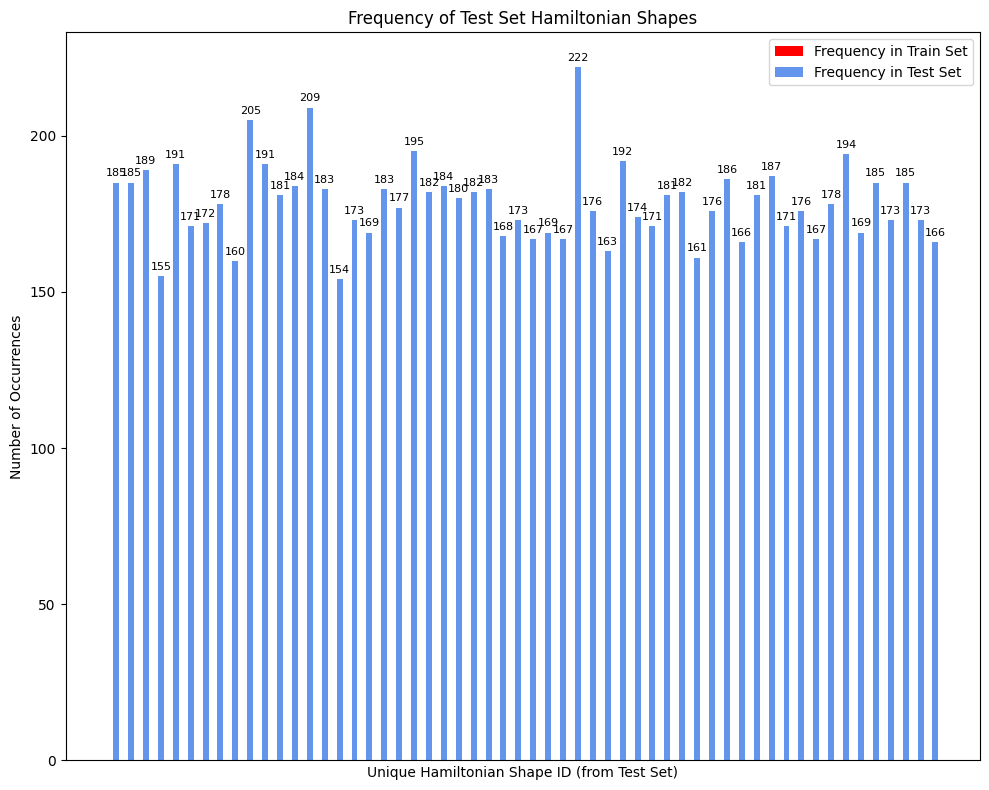

In [ ]:
import collections
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os

TRAIN_FILE = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_data/train.txt"
TEST_FILE = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_data/test.txt"

from typing import Union

def extract_shape_from_line(line: str) -> Union[tuple, None]:
    """
    Parses a line from the dataset and returns the tuple of directions (the shape).
    Example: "[SOS] ab SOUTH cd ... [SEP] ..." -> ('SOUTH', 'EAST', ...)
    """
    try:
        parts = line.strip().split()
        sep_idx = parts.index("[SEP]")

        path_parts = parts[1:sep_idx]
    
        directions = tuple(path_parts[1::2])
        return directions
    except (ValueError, IndexError):
        return None

def analyze_file_shapes(filepath: str) -> collections.Counter:
    """
    Reads a dataset file and returns a Counter with the frequency of each shape.
    """
    if not os.path.exists(filepath):
        print(f"Error: File not found at {filepath}")
        return collections.Counter()
        
    shape_counts = collections.Counter()
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc=f"Analyzing {os.path.basename(filepath)}"):
            shape = extract_shape_from_line(line)
            if shape:
                shape_counts[shape] += 1
    return shape_counts

def plot_shape_distributions(train_counts, test_counts):
    """
    Creates a histogram comparing the distribution of test set shapes
    in both the training and test sets.
    """
    # Get the unique shapes that actually appear in the test set
    test_shape_list = sorted(list(test_counts.keys()))
    
    # Get the frequency of these specific shapes in both datasets
    # For the train set, this count should be 0 if the split is correct.
    counts_in_test_set = [test_counts[shape] for shape in test_shape_list]
    counts_in_train_set = [train_counts.get(shape, 0) for shape in test_shape_list]

    x = np.arange(len(test_shape_list))  
    width = 0.4 
    fig, ax = plt.subplots(figsize=(10, 8))
    rects1 = ax.bar(x - width/2, counts_in_train_set, width, label='Frequency in Train Set', color='red')
    rects2 = ax.bar(x + width/2, counts_in_test_set, width, label='Frequency in Test Set', color='cornflowerblue')

    ax.set_ylabel('Number of Occurrences')
    ax.set_title('Frequency of Test Set Hamiltonian Shapes')
    ax.set_xlabel('Unique Hamiltonian Shape ID (from Test Set)')
    ax.set_xticks([])
    ax.legend()
    ax.bar_label(rects2, padding=3, fmt='%d', fontsize=8)

    if any(c > 0 for c in counts_in_train_set):
        ax.text(0.5, 0.5, 'WARNING: OVERLAP DETECTED!',
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes,
                fontsize=40, color='red', alpha=0.5,
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

    fig.tight_layout()
    plt.show()


if __name__ == '__main__':
    print("--- Analyzing Hamiltonian Shape Distributions ---")
    train_counts = analyze_file_shapes(TRAIN_FILE)
    test_counts = analyze_file_shapes(TEST_FILE)

    print("\n--- Analysis Results ---")
    
    train_shapes = set(train_counts.keys())
    test_shapes = set(test_counts.keys())

    print(f"Total examples analyzed in train file: {sum(train_counts.values())}")
    print(f"Total examples analyzed in test file: {sum(test_counts.values())}")
    print("-" * 20)
    print(f"Number of unique shapes found in train set: {len(train_shapes)}")
    print(f"Number of unique shapes found in test set: {len(test_shapes)}")
    
    overlap = train_shapes.intersection(test_shapes)
    
    print("-" * 20)
    print(f"Number of overlapping shapes between train and test: {len(overlap)}")
    
    if len(overlap) == 0:
        print("\n✅ SUCCESS: The train and test sets are perfectly disjoint in terms of Hamiltonian shapes.")
        print("This confirms the holdout set was configured correctly.")
    else:
        print("\n❌ CRITICAL WARNING: Overlap detected between train and test shapes.")
        print("The holdout set is not clean. This invalidates the generalization results.")
        print("Sample of overlapping shapes:", list(overlap)[:3])
        
    if test_counts:
        print("\n--- Generating Visualization ---")
        plot_shape_distributions(train_counts, test_counts)
    else:
        print("\nCould not generate visualization because test set was empty or could not be read.")